# SOCRAT - SPACEDOS Decoder

In [5]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import os

# Data parsers

## MOBITEX CRC check procedures

In [6]:
import datetime
import sys
import os
import struct

year  = 0 
month = 0
day   = 0
hour  = 0
min   = 0
sec   = 0


def calculate_tm_checksum(bytes):
    if sys.version_info >= (3, 0):
        return (0x00ff - sum(bytes)) & 0xff
    else:
        def sum_of_bytes():
            sum = 0
            for x in range(len(bytes)):
                sum += ord(bytes[x])
            return sum
        return (0x00ff - sum_of_bytes()) & 0xff

def check_tm_packet(data):
    CCSDS_HEADER_SIZE = 3
    CCSDS_CRC_SIZE = 2
    CCSDS_TM_HEADER_PREAMBLE1 = 0x55    # = 127d
    CCSDS_TM_HEADER_PREAMBLE2 = 0x00
    max_meaningful_length = 120

    # receive packet primary header
    if len(data) < CCSDS_HEADER_SIZE:
        print("TM_ERROR (Insufficient data length)")
        return [False, 0, 0]

    # parse packet primary header 
    preamble1, preamble2_eLengthHigh, eLengthLow = struct.unpack('>BBB', data[0:CCSDS_HEADER_SIZE])
    preamble2  = (preamble2_eLengthHigh & 0xC0)
    lengthHigh = (preamble2_eLengthHigh & 0x3F)
    payload_length = lengthHigh*256 + eLengthLow + 1
    packet_length = CCSDS_HEADER_SIZE + payload_length

    # check for first byte of the preamble
    if preamble1 != CCSDS_TM_HEADER_PREAMBLE1:
        print('TM_ERROR (Unexpected HEADER PREAMBLE1 (received 0x%02X but required 0x%02X))' %(preamble1, CCSDS_TM_HEADER_PREAMBLE1))
        return [False, 0, 0]

    if preamble2 != CCSDS_TM_HEADER_PREAMBLE2:
        print('TM_ERROR (Unexpected HEADER PREAMBLE2 (received 0x%02X but required 0x%02X))' %(preamble2, CCSDS_TM_HEADER_PREAMBLE2))
        return [False, 0, 0]
        
    if packet_length > max_meaningful_length:
        print('TM_ERROR (Input data is too long (maximum is ', max_meaningful_length, ' but packet declares)', packet_length)
        return [False, 0, 0]

    if len(data) < packet_length:
        print('TM_ERROR (Input data is too short (packet declares ', packet_length, ' but obtained only ', len(data), '))')
        return [False, 0, 0]

    packet = data[0:packet_length]

    calc_checksum = calculate_tm_checksum(packet[0:-CCSDS_CRC_SIZE])
    received_checksum, = struct.unpack('>H', packet[-CCSDS_CRC_SIZE:])

    if calc_checksum != received_checksum:
        return [False, calc_checksum, received_checksum]
    else:
        return [True, calc_checksum, received_checksum]

###############################################################################

initialValue = 0x0000;
finalXor     = 0x0000;
crc16Table   = [
    0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50A5, 0x60C6, 0x70E7, 0x8108, 0x9129, 0xA14A, 0xB16B, 0xC18C, 0xD1AD, 0xE1CE, 0xF1EF, 
    0x1231, 0x0210, 0x3273, 0x2252, 0x52B5, 0x4294, 0x72F7, 0x62D6, 0x9339, 0x8318, 0xB37B, 0xA35A, 0xD3BD, 0xC39C, 0xF3FF, 0xE3DE, 
    0x2462, 0x3443, 0x0420, 0x1401, 0x64E6, 0x74C7, 0x44A4, 0x5485, 0xA56A, 0xB54B, 0x8528, 0x9509, 0xE5EE, 0xF5CF, 0xC5AC, 0xD58D, 
    0x3653, 0x2672, 0x1611, 0x0630, 0x76D7, 0x66F6, 0x5695, 0x46B4, 0xB75B, 0xA77A, 0x9719, 0x8738, 0xF7DF, 0xE7FE, 0xD79D, 0xC7BC, 
    0x48C4, 0x58E5, 0x6886, 0x78A7, 0x0840, 0x1861, 0x2802, 0x3823, 0xC9CC, 0xD9ED, 0xE98E, 0xF9AF, 0x8948, 0x9969, 0xA90A, 0xB92B, 
    0x5AF5, 0x4AD4, 0x7AB7, 0x6A96, 0x1A71, 0x0A50, 0x3A33, 0x2A12, 0xDBFD, 0xCBDC, 0xFBBF, 0xEB9E, 0x9B79, 0x8B58, 0xBB3B, 0xAB1A, 
    0x6CA6, 0x7C87, 0x4CE4, 0x5CC5, 0x2C22, 0x3C03, 0x0C60, 0x1C41, 0xEDAE, 0xFD8F, 0xCDEC, 0xDDCD, 0xAD2A, 0xBD0B, 0x8D68, 0x9D49, 
    0x7E97, 0x6EB6, 0x5ED5, 0x4EF4, 0x3E13, 0x2E32, 0x1E51, 0x0E70, 0xFF9F, 0xEFBE, 0xDFDD, 0xCFFC, 0xBF1B, 0xAF3A, 0x9F59, 0x8F78, 
    0x9188, 0x81A9, 0xB1CA, 0xA1EB, 0xD10C, 0xC12D, 0xF14E, 0xE16F, 0x1080, 0x00A1, 0x30C2, 0x20E3, 0x5004, 0x4025, 0x7046, 0x6067, 
    0x83B9, 0x9398, 0xA3FB, 0xB3DA, 0xC33D, 0xD31C, 0xE37F, 0xF35E, 0x02B1, 0x1290, 0x22F3, 0x32D2, 0x4235, 0x5214, 0x6277, 0x7256, 
    0xB5EA, 0xA5CB, 0x95A8, 0x8589, 0xF56E, 0xE54F, 0xD52C, 0xC50D, 0x34E2, 0x24C3, 0x14A0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405, 
    0xA7DB, 0xB7FA, 0x8799, 0x97B8, 0xE75F, 0xF77E, 0xC71D, 0xD73C, 0x26D3, 0x36F2, 0x0691, 0x16B0, 0x6657, 0x7676, 0x4615, 0x5634, 
    0xD94C, 0xC96D, 0xF90E, 0xE92F, 0x99C8, 0x89E9, 0xB98A, 0xA9AB, 0x5844, 0x4865, 0x7806, 0x6827, 0x18C0, 0x08E1, 0x3882, 0x28A3, 
    0xCB7D, 0xDB5C, 0xEB3F, 0xFB1E, 0x8BF9, 0x9BD8, 0xABBB, 0xBB9A, 0x4A75, 0x5A54, 0x6A37, 0x7A16, 0x0AF1, 0x1AD0, 0x2AB3, 0x3A92, 
    0xFD2E, 0xED0F, 0xDD6C, 0xCD4D, 0xBDAA, 0xAD8B, 0x9DE8, 0x8DC9, 0x7C26, 0x6C07, 0x5C64, 0x4C45, 0x3CA2, 0x2C83, 0x1CE0, 0x0CC1, 
    0xEF1F, 0xFF3E, 0xCF5D, 0xDF7C, 0xAF9B, 0xBFBA, 0x8FD9, 0x9FF8, 0x6E17, 0x7E36, 0x4E55, 0x5E74, 0x2E93, 0x3EB2, 0x0ED1, 0x1EF0
]

def HIGH_BYTE_16(var):
    return ((var & 0xFF00) >> 8)

def LOW_BYTE_16(var):
    return (var & 0x00FF)

def calculateCrc16Ccitt(in_data, in_length):
    crc = initialValue
    for i in range(0, in_length):
        crc = (LOW_BYTE_16(crc) << 8) ^ crc16Table[LOW_BYTE_16((HIGH_BYTE_16(crc) ^ in_data[i]))]
    return (crc ^ finalXor)

def get_radio_id(file):
    file.seek(10, 0)
    raw_radio_id = file.read(1)
    
    radioId = struct.unpack('B', raw_radio_id)
 
    return radioId
    
def get_date(file):
    file.seek(0)
    raw_timestamp = file.read(6)
    raw_year, raw_month, raw_day, raw_hour, raw_min, raw_sec = struct.unpack('BBBBBB', raw_timestamp)
    
    year  =  (((raw_year >> 4) & (0x0F)) * 10) + ((raw_year) & (0x0F))
    month = (((raw_month >> 4) & (0x0F)) * 10) + ((raw_month) & (0x0F))
    day   =   (((raw_day >> 4) & (0x0F)) * 10) + ((raw_day) & (0x0F))
    hour  =  (((raw_hour >> 4) & (0x0F)) * 10) + ((raw_hour) & (0x0F))
    min   =   (((raw_min >> 4) & (0x0F)) * 10) + ((raw_min) & (0x0F))
    sec   =   (((raw_sec >> 4) & (0x0F)) * 10) + ((raw_sec) & (0x0F))
    
    return [year, month, day, hour, min, sec]

def check_crc(file):
    # calculate MOBITEX CRC
    file.seek(12, 0)
    mobData = file.read(124)
    calc_crc = calculateCrc16Ccitt(mobData, 124)
    
    # jump to MOBITEX CRC
    file.seek(136, 0)
    
    raw_crc = file.read(2)
    rcvd_crc, = struct.unpack('>H', raw_crc)
    
    if calc_crc == rcvd_crc:    
        #print("MOBITEX CRC  = 0x%04X (matches)" %rcvd_crc)
        return [True, calc_crc, rcvd_crc]
    else:
        #print("MOBITEX CRC  = 0x%04X (NOT MATCHES! calculated CRC = 0x%04X)" %(rcvd_crc,calc_crc))
        return [False, calc_crc, rcvd_crc]


def check_MOBITEX(inFilePath):
    
    # open Mobitex file for reading
    rawDataFile = open(inFilePath, 'rb')


    ###############################################################################
    # MOBITEX VERIFICATION
    ###############################################################################
    # check and verify MOBITEX CRC
    is_mbtx_valid, calc_crc, rcvd_crc = check_crc(rawDataFile)

    
    # read and decode reception time
    year, month, day, hour, min, sec = get_date(rawDataFile)

    ###############################################################################
    # TELEMETRY VERIFICATION
    ###############################################################################
    # jump to TM data
    rawDataFile.seek(14, 0)
    # read TM data
    tmData = rawDataFile.read(120)
    is_tm_valid, calc_tm_crc, rcvd_tm_crc = check_tm_packet(tmData)

    # close input file
    rawDataFile.close()

    return [is_mbtx_valid, is_tm_valid, (year, month, day, hour, min, sec)]


# BESD

In [5]:
h = b'\x30\x00\xc6' #5xBESD 100B

try:
    os.remove('socrat_beacon.csv')
except:
    pass

file_object = open('socrat_beacon.csv', 'a')

for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            check = check_MOBITEX(fn)
            print((s).hex())  
    
            next = 0
            value = []
            offset = 0
            for b in s:
                value.append((b >> 1) | next)
                print(hex(value[-1])[2:] , end=' ' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()
            
            if (not check[0]):
                print('Error MOBITEX ########################################################')
            if (not check[1]):
                print('Error Telemetry ******************************************************')
                
            print("%02d/%02d/%02d %02d:%02d:%02d" %check[2])

            for n in range(24,120,20):
                message = '$BESD'
                for i in range(n,n+18,2):
                    message += ',' + str(value[i]+value[i+1]*2**8)
                #message += ',' + str(value[2])
                message += '\n'
                if (check[1]):
                    file_object.write(message)
                print(message, end='') 
            print()
            
# Close the file
file_object.close()

#$BESD,0,3,2,2,1,0,0,0,0
None

data/Socrat-R11/3990A/Report RS19S_Socrat/000_0628.SOKRAT_R 17
200325120001cccc57653d077ead5500683000c60000000018004200800068004c00b70006000400000000001a00440084006e0052001a0006000400000000001c004e009e00740058001c0006000400000000001e005600a2007c005c002200060004000000000020005a00aa00820064002600080004000088000000000000000000000000ffffb1fb
10 1 92 89 0 0 e6 66 2b b2 9e 83 bf 56 aa 80 34 18 0 63 0 0 0 0 c 0 21 0 40 0 34 0 26 0 5b 80 3 0 2 0 0 0 0 0 d 0 22 0 42 0 37 0 29 0 d 0 3 0 2 0 0 0 0 0 e 0 27 0 4f 0 3a 0 2c 0 e 0 3 0 2 0 0 0 0 0 f 0 2b 0 51 0 3e 0 2e 0 11 0 3 0 2 0 0 0 0 0 10 0 2d 0 55 0 41 0 32 0 13 0 4 0 2 0 0 44 0 0 0 0 0 0 0 0 0 0 0 0 7f ff d8 fd 

Error MOBITEX ########################################################
Error Telemetry ******************************************************
20/03/25 12:00:01
$BESD,12,33,64,52,38,32859,3,2,0
$BESD,13,34,66,55,41,13,3,2,0
$BESD,14,39,79,58,44,14,3,2,0
$BESD,15,43,81,62,46,17,3,2,0
$BESD,16,45,85,65,50,19,4,2,17408

data/Socrat-R11/39

10 1 92 88 ab 99 e6 66 2b b2 9e 83 bf 56 aa 80 34 18 0 63 0 0 0 0 c 0 7c 0 b9 0 af 0 82 0 18 0 6 0 2 0 0 0 0 0 d 0 7e 0 c0 0 b4 0 85 0 18 0 6 0 2 0 0 0 0 0 e 0 81 0 c7 0 b7 0 85 0 19 0 6 0 2 0 0 0 0 0 f 0 86 0 ca 0 ba 0 86 0 19 0 7 0 2 0 0 0 0 0 10 0 88 0 ce 0 be 0 89 0 1a 0 7 0 2 0 0 23 0 0 0 0 0 0 0 0 0 0 0 0 7f ff 87 21 

20/03/25 11:57:33
$BESD,12,124,185,175,130,24,6,2,0
$BESD,13,126,192,180,133,24,6,2,0
$BESD,14,129,199,183,133,25,6,2,0
$BESD,15,134,202,186,134,25,7,2,0
$BESD,16,136,206,190,137,26,7,2,8960

data/Socrat-R11/3990S/Report RS19S_Socrat/000_1008.SOKRAT_R 17
200325120037cccc57653d077ead5500683000c60000000036008e012200be00a4003c000c00080000000000380098012600c000ac0042000c000800000000003a009a013200ca00ba0044000e000800000000003c009e013e00ce00be0048000e000800000000003e00a4014600d800c0004e001000080000eb000000000000000000000000ffff1d38
10 1 92 89 0 1b e6 66 2b b2 9e 83 bf 56 aa 80 34 18 0 63 0 0 0 0 1b 0 47 0 91 0 5f 0 52 0 1e 0 6 0 4 0 0 0 0 0 1c 0 4c 0 93 0 60 0 56 0 21 0 


20/03/27 11:36:11
$BESD,62,169,292,228,188,78,12,7,0
$BESD,63,173,305,236,195,79,12,7,0
$BESD,64,182,312,245,208,79,12,7,0
$BESD,65,214,362,309,256,82,12,7,0
$BESD,66,231,395,338,276,84,12,7,27648

data/Socrat-R11/4021S/Report RS19S_Socrat/000_1030.SOKRAT_R 17
200327113259cccc57653d077ead5500683000c6000000002c0092010200ea00b8002c000c000400000000002e0094010800f400be002e000c0004000000000030009a011200f800c20030000c000400000000003200a0011a010400c60034000c000400000000003400a40120010a00c6003a000c000400000b000000000000000000000000ffff2d11
10 1 93 88 99 2c e6 66 2b b2 9e 83 bf 56 aa 80 34 18 0 63 0 0 0 0 16 0 49 0 81 0 75 0 5c 0 16 0 6 0 2 0 0 0 0 0 17 0 4a 0 84 0 7a 0 5f 0 17 0 6 0 2 0 0 0 0 0 18 0 4d 0 89 0 7c 0 61 0 18 0 6 0 2 0 0 0 0 0 19 0 50 0 8d 0 82 0 63 0 1a 0 6 0 2 0 0 0 0 0 1a 0 52 0 90 0 85 0 63 0 1d 0 6 0 2 0 0 5 80 0 0 0 0 0 0 0 0 0 0 0 7f ff 96 88 

20/03/27 11:32:59
$BESD,22,73,129,117,92,22,6,2,0
$BESD,23,74,132,122,95,23,6,2,0
$BESD,24,77,137,124,97,24,6,2,0
$BESD,25,80,141,

data/Socrat-R11/4021S/Report RS19S_Socrat/000_1034.SOKRAT_R 17
200327113351cccc57653d077ead5500683000c600000000040018002600140012000600000002000000000006001a002a001e001c000600020002000000000008001e00320020001e000a0002000200000000000a0020003e00240020000a0002000200000000000c0026004a00300026000a00020002000010000000000000000000000000ffff47f5
10 1 93 88 99 a8 e6 66 2b b2 9e 83 bf 56 aa 80 34 18 0 63 0 0 0 0 2 0 c 0 13 0 a 0 9 0 3 0 0 0 1 0 0 0 0 0 3 0 d 0 15 0 f 0 e 0 3 0 1 0 1 0 0 0 0 0 4 0 f 0 19 0 10 0 f 0 5 0 1 0 1 0 0 0 0 0 5 0 10 0 1f 0 12 0 10 0 5 0 1 0 1 0 0 0 0 0 6 0 13 0 25 0 18 0 13 0 5 0 1 0 1 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 7f ff a3 fa 

20/03/27 11:33:51
$BESD,2,12,19,10,9,3,0,1,0
$BESD,3,13,21,15,14,3,1,1,0
$BESD,4,15,25,16,15,5,1,1,0
$BESD,5,16,31,18,16,5,1,1,0
$BESD,6,19,37,24,19,5,1,1,2048

data/Socrat-R11/4021S/Report RS19S_Socrat/000_1016.SOKRAT_R 17
200327113132cccc57653d077ead5500683000c60000000022011401a601820116003600100004000000000024011801b4018c011a003c00100004000000

data/Socrat-R11/4020A/Report RS19S_Socrat/000_0593.SOKRAT_R 17
200327113102cccc57653d077ead5500683000c6000000000e00aa0120012600d600260008000200000000001000bc0132013a00e600280008000200000000001200d00148014a00ea00280008000200000000001400de015e015000f200280008000200000000001600ee016c015a00fc002c000a000200009c000000000000000000000000fffffe66
10 1 93 88 98 81 66 66 2b b2 9e 83 bf 56 aa 80 34 18 0 63 0 0 0 0 7 0 55 0 90 0 93 0 6b 0 13 0 4 0 1 0 0 0 0 0 8 0 5e 0 99 0 9d 0 73 0 14 0 4 0 1 0 0 0 0 0 9 0 68 0 a4 0 a5 0 75 0 14 0 4 0 1 0 0 0 0 0 a 0 6f 0 af 0 a8 0 79 0 14 0 4 0 1 0 0 0 0 0 b 0 77 0 b6 0 ad 0 7e 0 16 0 5 0 1 0 0 4e 0 0 0 0 0 0 0 0 0 0 0 0 7f ff ff 33 

20/03/27 11:31:02
$BESD,7,85,144,147,107,19,4,1,0
$BESD,8,94,153,157,115,20,4,1,0
$BESD,9,104,164,165,117,20,4,1,0
$BESD,10,111,175,168,121,20,4,1,0
$BESD,11,119,182,173,126,22,5,1,19968

data/Socrat-R11/4020A/Report RS19S_Socrat/000_0637.SOKRAT_R 17
200327113619cccc57653d077ead5500683000c6000000008601e6014602da024402aa0018000e00000

## Visualisation of parsed data

<IPython.core.display.Javascript object>


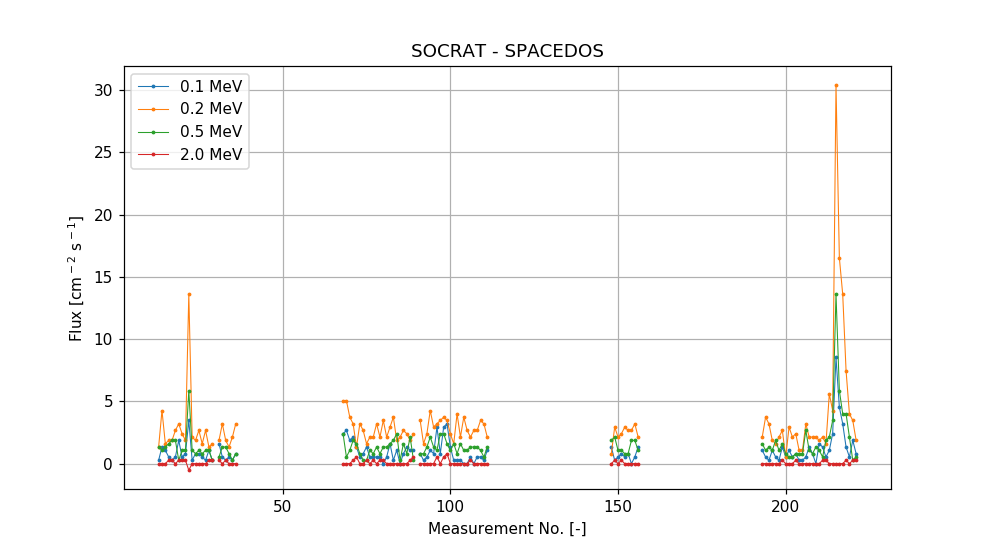

Text(0.5, 1.0, 'SOCRAT - SPACEDOS')

In [7]:
df = pd.read_csv('socrat_beacon_single.csv',header=None)
run = df.loc[:,1:].copy()
run[2] = (df[0]-1)*30+df[2]
run = run.set_index(run[2])
run = run.loc[:,2:].diff()
#run[1] = df[2]
#run = run.set_index(run[1])
#run = run[run.index<19]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run.index,run[3]*4/15, marker='.', lw=0.7, markersize=3, label='0.1 MeV')
plt.plot(run.index,(run[4]+run[5])*4/15, marker='.', lw=0.7, markersize=3, label='0.2 MeV')
plt.plot(run.index,(run[6]+run[7])*4/15, marker='.', lw=0.7, markersize=3, label='0.5 MeV')
plt.plot(run.index,(run[8]+run[9])*4/15, marker='.', lw=0.7, markersize=3, label='2.0 MeV')
plt.legend()
#plt.xlim(0,10)
#plt.ylim(0,18)
plt.grid()

plt.xlabel('Measurement No. [-]')
plt.ylabel(r'Flux [cm$^-$$^2$ s$^-$$^1$]')
plt.title('SOCRAT - SPACEDOS')

<IPython.core.display.Javascript object>


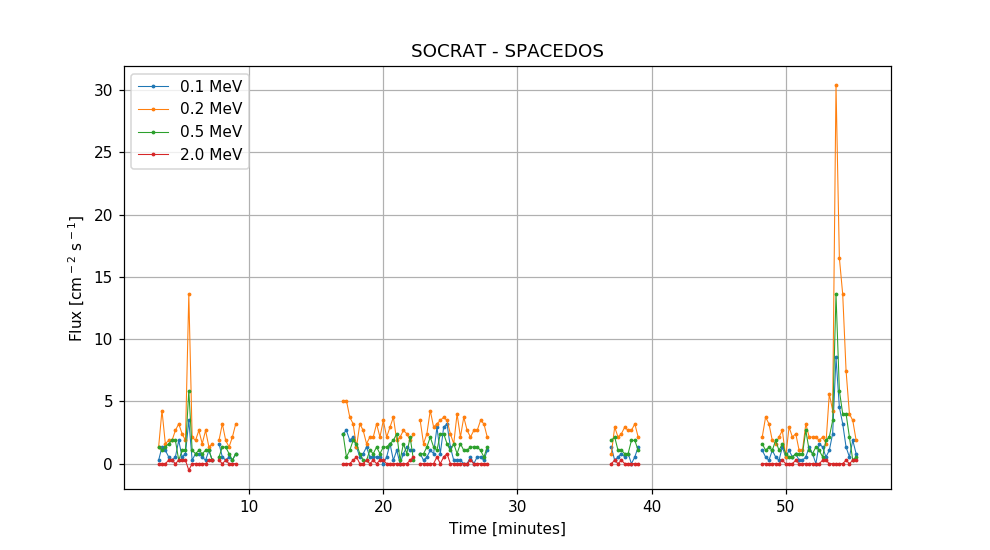

Text(0.5, 1.0, 'SOCRAT - SPACEDOS')

In [72]:
df = pd.read_csv('socrat_beacon_single.csv',header=None)
run = df.loc[:,1:].copy()
run[2] = (df[0]-1)*30+df[2]
run = run.set_index(run[2])
run = run.loc[:,2:].diff()
#run[1] = df[2]
#run = run.set_index(run[1])
#run = run[run.index<19]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run.index*15/60,run[3]*4/15, lw=0.7, marker='.', markersize=3, label='0.1 MeV')
plt.plot(run.index*15/60,(run[4]+run[5])*4/15, lw=0.7, marker='.', markersize=3, label='0.2 MeV')
plt.plot(run.index*15/60,(run[6]+run[7])*4/15, lw=0.7, marker='.', markersize=3, label='0.5 MeV')
plt.plot(run.index*15/60,(run[8]+run[9])*4/15, lw=0.7, marker='.', markersize=3, label='2.0 MeV')
plt.legend()
#plt.xlim(0,10)
#plt.ylim(0,18)
plt.grid()
#plt.yscale('log')

plt.xlabel('Time [minutes]')
plt.ylabel(r'Flux [cm$^-$$^2$ s$^-$$^1$]')
plt.title('SOCRAT - SPACEDOS')

<IPython.core.display.Javascript object>


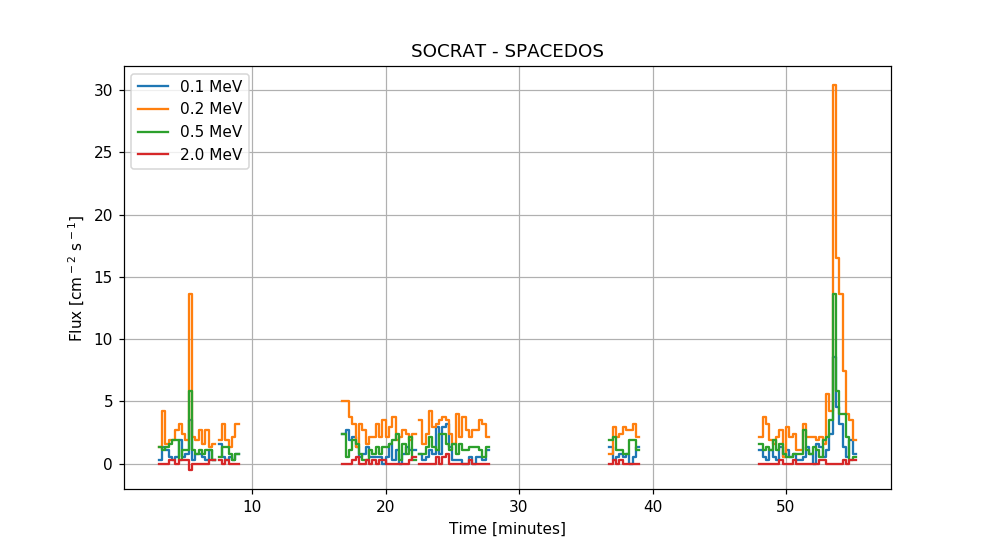

Text(0.5, 1.0, 'SOCRAT - SPACEDOS')

In [55]:
df = pd.read_csv('socrat_beacon_single.csv',header=None)
run = df.loc[:,1:].copy()
run[2] = (df[0]-1)*30+df[2]
run = run.set_index(run[2])
run = run.loc[:,2:].diff()
#run[1] = df[2]
#run = run.set_index(run[1])
#run = run[run.index<19]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run.index*15/60,run[3]*4/15, label='0.1 MeV', drawstyle='steps')
plt.plot(run.index*15/60,(run[4]+run[5])*4/15, label='0.2 MeV', drawstyle='steps')
plt.plot(run.index*15/60,(run[6]+run[7])*4/15, label='0.5 MeV', drawstyle='steps')
plt.plot(run.index*15/60,(run[8]+run[9])*4/15, label='2.0 MeV', drawstyle='steps')
plt.legend()
#plt.xlim(0,10)
#plt.ylim(0,18)
plt.grid()

plt.xlabel('Time [minutes]')
plt.ylabel(r'Flux [cm$^-$$^2$ s$^-$$^1$]')
plt.title('SOCRAT - SPACEDOS')

# Other parsers

# HKSD

In [61]:
h = b'\x30\x00\xde' #HKSD 112B

for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            check = check_MOBITEX(fn)
            print( (s).hex())  
    
            next = 0
            value = []
            offset = 0
            for b in s:
                value.append((b >> 1) | next)
                print(hex(value[-1])[2:] , end=' ' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()

            if (not check[0]):
                print('Error MOBITEX')
            if (not check[1]):
                print('Error Telemetry')
                
            print("%02d/%02d/%02d %02d:%02d:%02d" %check[2])

            start = 23
            
            print('$HKSD',end=',')
            print(value[start]+value[start+1]*2**8,end=',')
            print(value[start+2]*2**32+value[start+3]*2**16+value[start+4]*2**8+value[start+5],end=',')
            for i in range(start+7,(start+7)+50*2,2):
                print(value[i]+value[i+1]*2**8,end=',')
            print()    
            print()    

#$HKSD,0,e,8003,ff,0,0,7ff4,3,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
None

# DPSD

In [58]:
h = b'\x30\x00\x2e' #DPSD 24B

print(h)

os.remove('socrat.csv')
file_object = open('socrat.csv', 'a')

for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            check = check_MOBITEX(fn)
            print( (s).hex())  
    
            next = 0
            value = []
            offset = 0
            for b in s:
                value.append((b >> 1) | next)
                print(hex(value[-1])[2:] , end=' ' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()
           
            n=22

            if (not check[0]):
                print('Error MOBITEX ########################################################')
            if (not check[1]):
                print('Error Telemetry ******************************************************')
                
            print("%02d/%02d/%02d %02d:%02d:%02d" %check[2])

            message = '$DPSD,'
            message += str(value[n]*2**16+value[n+1]*2**24+value[n+2]+value[n+3]*2**8)
            for i in range(n+4,n+22,2):
                message += ',' + str(value[i]+value[i+1]*2**8)
            message += ',' + str(value[2])
            message += '\n'
            print(message)  
            if (check[1]):
                file_object.write(message)

# Close the file
file_object.close()

None

b'0\x00.'


In [59]:
try:
    run = pd.read_csv('socrat.csv',header=None)
    #print(run[0])
    run.set_index(run[1],inplace=True)
    run = run.sort_index()
except:
    pass
None

<IPython.core.display.Javascript object>


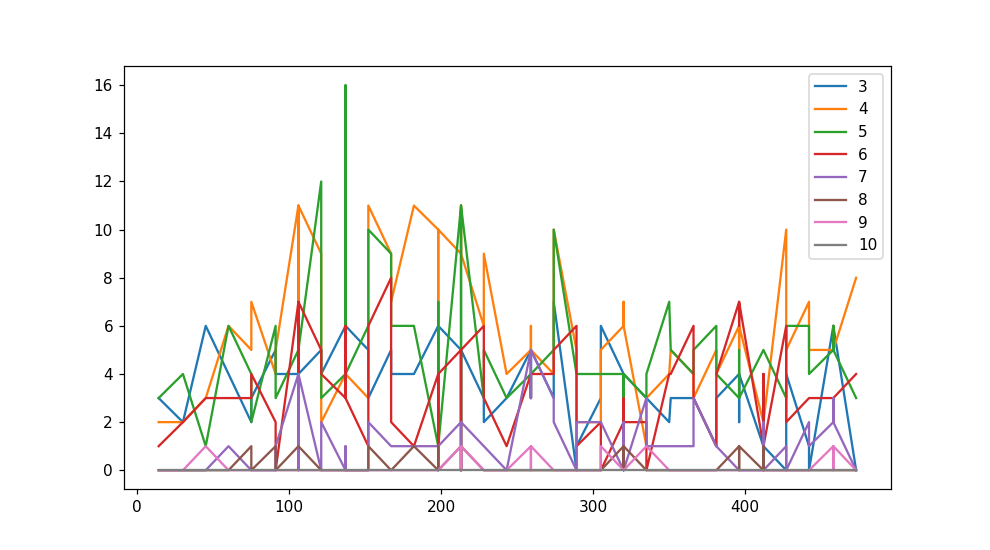

In [24]:
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[3])
plt.plot(run[1],run[4])
plt.plot(run[1],run[5])
plt.plot(run[1],run[6])
plt.plot(run[1],run[7])
plt.plot(run[1],run[8])
plt.plot(run[1],run[9])
plt.plot(run[1],run[10])
plt.legend()


<IPython.core.display.Javascript object>


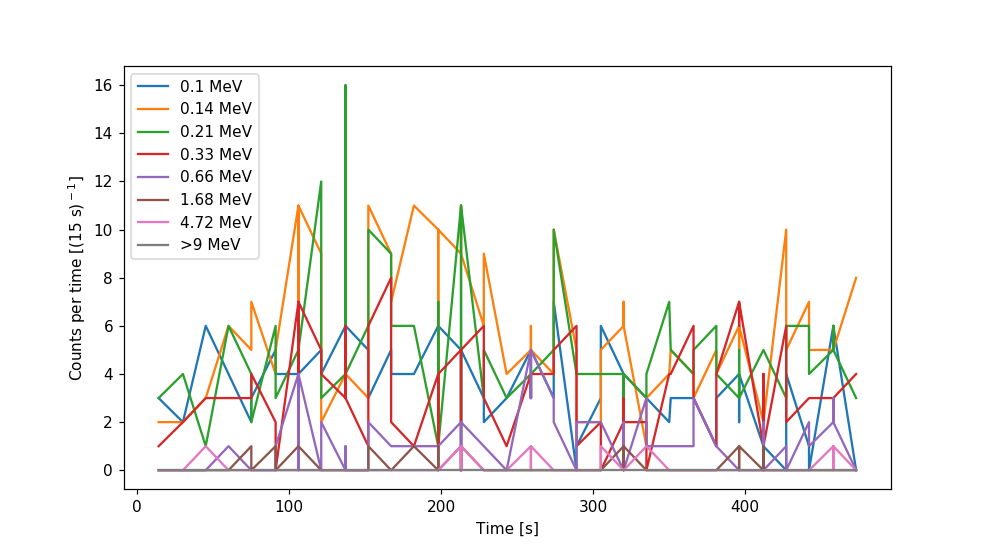

Text(0, 0.5, 'Counts per time [(15 s)$^-$$^1$]')

In [56]:
#run = df[(df[11]==17)|(df[11]==12)]
#run = df[df[11]==17]
#run = df[df[11]==16]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[3], label='0.1 MeV')
plt.plot(run[1],run[4], label='0.14 MeV')
plt.plot(run[1],run[5], label='0.21 MeV')
plt.plot(run[1],run[6], label='0.33 MeV')
plt.plot(run[1],run[7], label='0.66 MeV')
plt.plot(run[1],run[8], label='1.68 MeV')
plt.plot(run[1],run[9], label='4.72 MeV')
plt.plot(run[1],run[10], label='>9 MeV')
plt.legend()

plt.xlabel('Time [s]')
plt.ylabel(r'Counts per time [(15 s)$^-$$^1$]')

<IPython.core.display.Javascript object>


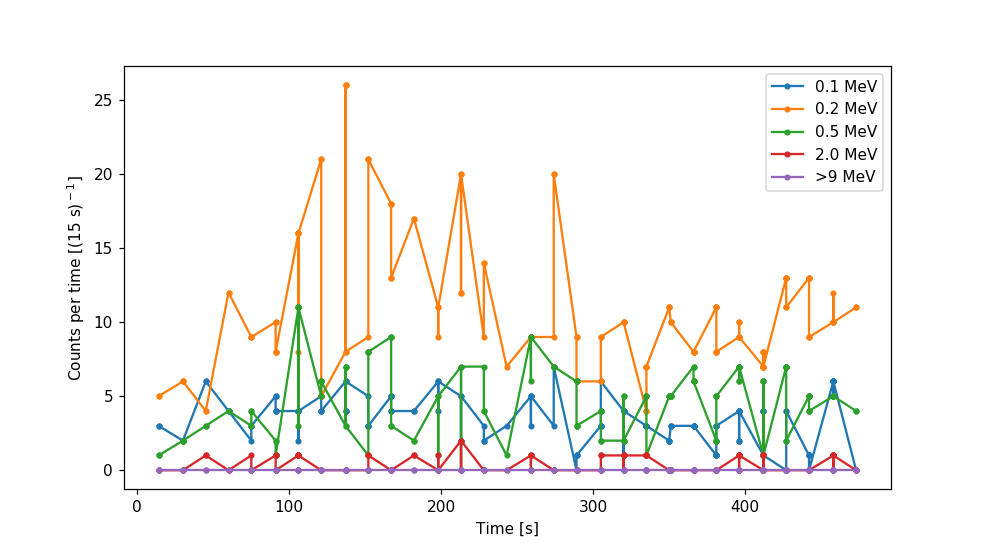

Text(0, 0.5, 'Counts per time [(15 s)$^-$$^1$]')

In [57]:
#run = df[(df[11]==17)|(df[11]==12)]
#run = df[df[11]==17]
#run = df[df[11]==16]
#run = df[df[11]==12]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run[1],run[3], marker='.', label='0.1 MeV')
plt.plot(run[1],run[4]+run[5], marker='.', label='0.2 MeV')
plt.plot(run[1],run[6]+run[7], marker='.', label='0.5 MeV')
plt.plot(run[1],run[8]+run[9], marker='.', label='2.0 MeV')
plt.plot(run[1],run[10], marker='.', label='>9 MeV')
plt.legend()

plt.xlabel('Time [s]')
plt.ylabel(r'Counts per time [(15 s)$^-$$^1$]')

In [28]:
df = pd.read_csv('socrat_beacon.csv',header=None)
df = df.reset_index() 
df = df.drop(['index'],axis=1)
#df.reset_index(drop=True, inplace=True)
df = df.drop_duplicates()
df.to_csv('socrat_beacon_single.csv',header=None, index=False)
#df

<IPython.core.display.Javascript object>


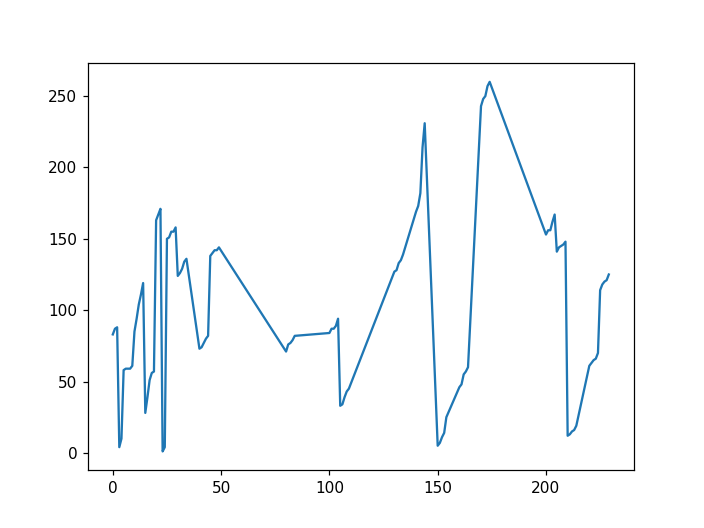

In [43]:
df[2].plot()

In [48]:
df = pd.read_csv('11_socrat_beacon_single.csv',header=None)
#df.set_index(df[1],inplace=True)
#df = df.sort_index()
#df = df.loc[~df.index.duplicated(keep='first')]
None
#df = df.loc[df[0] == 1]
#df

<IPython.core.display.Javascript object>


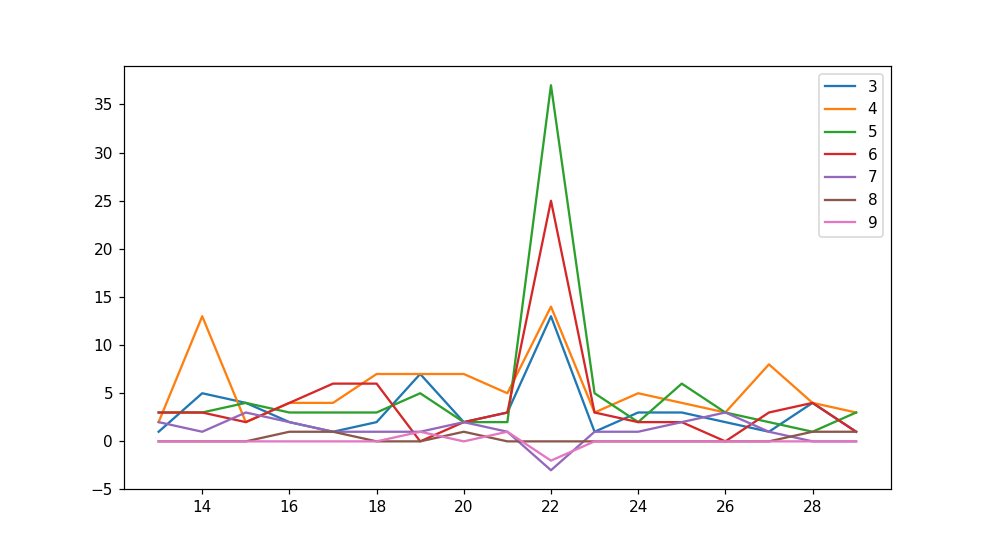

In [51]:
run = df.loc[df[0] == 1].loc[:,1:].copy()
run = run.set_index(run[2])

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run.index,run[3].diff())
plt.plot(run.index,run[4].diff())
plt.plot(run.index,run[5].diff())
plt.plot(run.index,run[6].diff())
plt.plot(run.index,run[7].diff())
plt.plot(run.index,run[8].diff())
plt.plot(run.index,run[9].diff())
plt.legend()


<IPython.core.display.Javascript object>


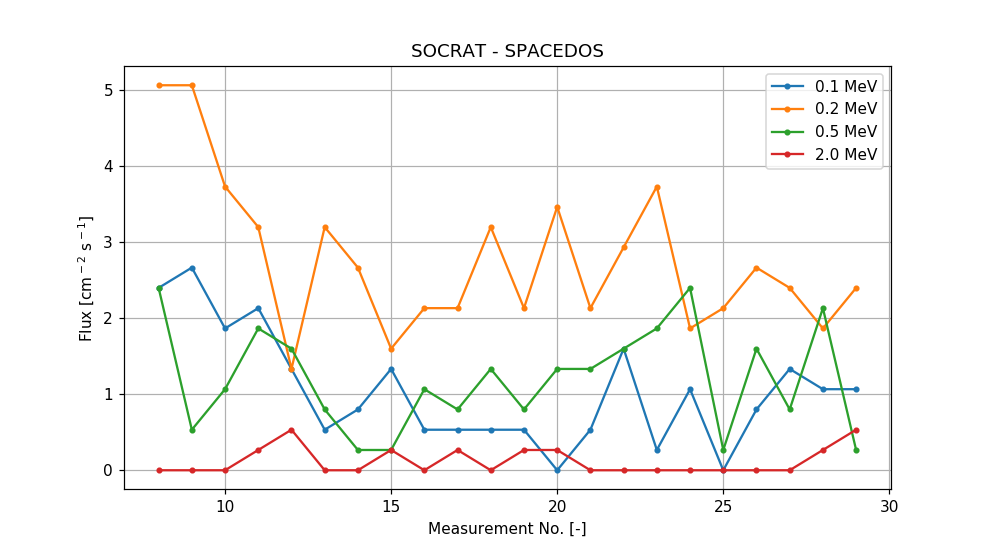

Text(0.5, 1.0, 'SOCRAT - SPACEDOS')

In [52]:
run = df.loc[df[0] == 3].loc[:,1:].copy()
run = run.set_index(run[2])
run = run.loc[:,2:].diff()
#run[1] = df[2]
#run = run.set_index(run[1])
#run = run[run.index<19]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(run.index,run[3]*4/15, marker='.', label='0.1 MeV')
plt.plot(run.index,(run[4]+run[5])*4/15, marker='.', label='0.2 MeV')
plt.plot(run.index,(run[6]+run[7])*4/15, marker='.', label='0.5 MeV')
plt.plot(run.index,(run[8]+run[9])*4/15, marker='.', label='2.0 MeV')
plt.legend()
#plt.xlim(0,10)
#plt.ylim(0,18)
plt.grid()

plt.xlabel('Measurement No. [-]')
plt.ylabel(r'Flux [cm$^-$$^2$ s$^-$$^1$]')
plt.title('SOCRAT - SPACEDOS')

In [62]:
#h = b'\x30\x00\xde' #HKSD 112B
#h = b'\x30\x00\xc6' #5xBESD 100B
h = b'\x30\x00\x2e' #DPSD 24B
#h = b'\x55\x00' #DPSD 24B

#h = b'\x00\x02\x00\x02\x00\x02\x00\x02\x00\x00\x00\x02'
#h = b'\x00\xde'
#h = b'\x02\x00\x06\x00'
#h = b'\x0a\x00\x04\x00'

print(h)
for fn in glob.iglob("data/**/*.SOKRAT_R", recursive=True): # generator, search immediate subdirectories 
    #print(fn)
    with open(fn, 'rb') as f:
        s = f.read()
        found = s.find(h)
        if (found>0):
            print(fn, found)
            print( (s).hex())  
    
            next = 0
            for b in s:
                print(hex((b >> 1) | next)[2:] , ' ', end='' )
                if ((b & 1) == 1):
                    next = 0x80
                else:
                    next = 0
            print()
            print()

None

b'0\x00.'
